In [1]:
import numpy as np
from view_sampler import ViewSampler, CameraConfig
from manipulated_object import ObjectPosition
from utils.orient import OrientUtils
from evaluate.evaluator import Evaluator
import loss_funcs
import cv2 as cv

from utils.image import ImageUtils
from tqdm.auto import tqdm
from collections import defaultdict 

In [2]:
INIT_LOCATION = (0, 1.3, 0.3)

LOSS_FUNCTIONS = [
    loss_funcs.IOU(),
    loss_funcs.MSE(),
    loss_funcs.NormMSE(norm="euclidean"),
    loss_funcs.WeightedSum(loss_funcs.IOU(), loss_funcs.NormMSE(norm="euclidean")),
    loss_funcs.MutualInformation(bins=100),
    loss_funcs.PeakSignalNoiseRatio(),
    loss_funcs.StructuralSimilarity(),
    loss_funcs.HausdorffDistance(),
    loss_funcs.AdaptedRandError(),
    loss_funcs.VariationOfInformation(),
]

OBJECTS = ["airplane", "hammer", "hand", "headphones", "mouse", "mug", "stapler", "toothpaste"]

ZFAR = 5

In [3]:
def create_viewer(obj_name: str, is_sim: bool = True) -> ViewSampler:
    location = (INIT_LOCATION[0], INIT_LOCATION[2] - 1.3, INIT_LOCATION[2])
    cam_config = CameraConfig(location, rotation=(np.pi / 2, 0, 0), fov=30, zfar=ZFAR)
    if is_sim:
        viewer = ViewSampler(f"data/{obj_name}/world_sim.xml", cam_config, simulation_time=0)
    else:
        viewer = ViewSampler(f"data/{obj_name}/world.xml", cam_config, simulation_time=0)
    return viewer

In [4]:
def generate_positions(count: int, ) -> list[ObjectPosition]:
    orients = OrientUtils.generate_random(count)
    positions = [ObjectPosition(orient, INIT_LOCATION) for orient in orients]
    return positions

In [5]:
def get_views(viewer: ViewSampler, pos1: ObjectPosition, pos2: ObjectPosition, depth: bool) -> tuple[np.ndarray, np.ndarray]:
    img1, _ = viewer.get_view_cropped(pos1, depth=depth, allow_simulation=False)
    img2, _ = viewer.get_view_cropped(pos2, depth=depth, allow_simulation=False)
    return img1, img2

In [6]:
import matplotlib.pyplot as plt
import math
# %matplotlib qt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        plt.figure()
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    for i in range(len(col_labels)):
        for j in range(len(row_labels)):
            text = ax.text(j, i, round(data[i, j],2),
                        ha="center", va="center", color="w")
            
    return im, cbar


In [7]:
n = 24

init_pos = np.array([0,0,np.pi])
uni_orients = [list(init_pos)]

q = np.array([1, 0, 0])
delta = np.linspace(0, np.pi/2, num=n+1)

for i in range(n):
    uni_orients.append(list(init_pos + delta[i+1]*q))

# uni_orients = OrientUtils.generate_random(20)
uni_positions = [ObjectPosition(orient, INIT_LOCATION) for orient in uni_orients]
len(uni_positions)

25

In [8]:
object_name = OBJECTS[1]
viewer = create_viewer(object_name, False)


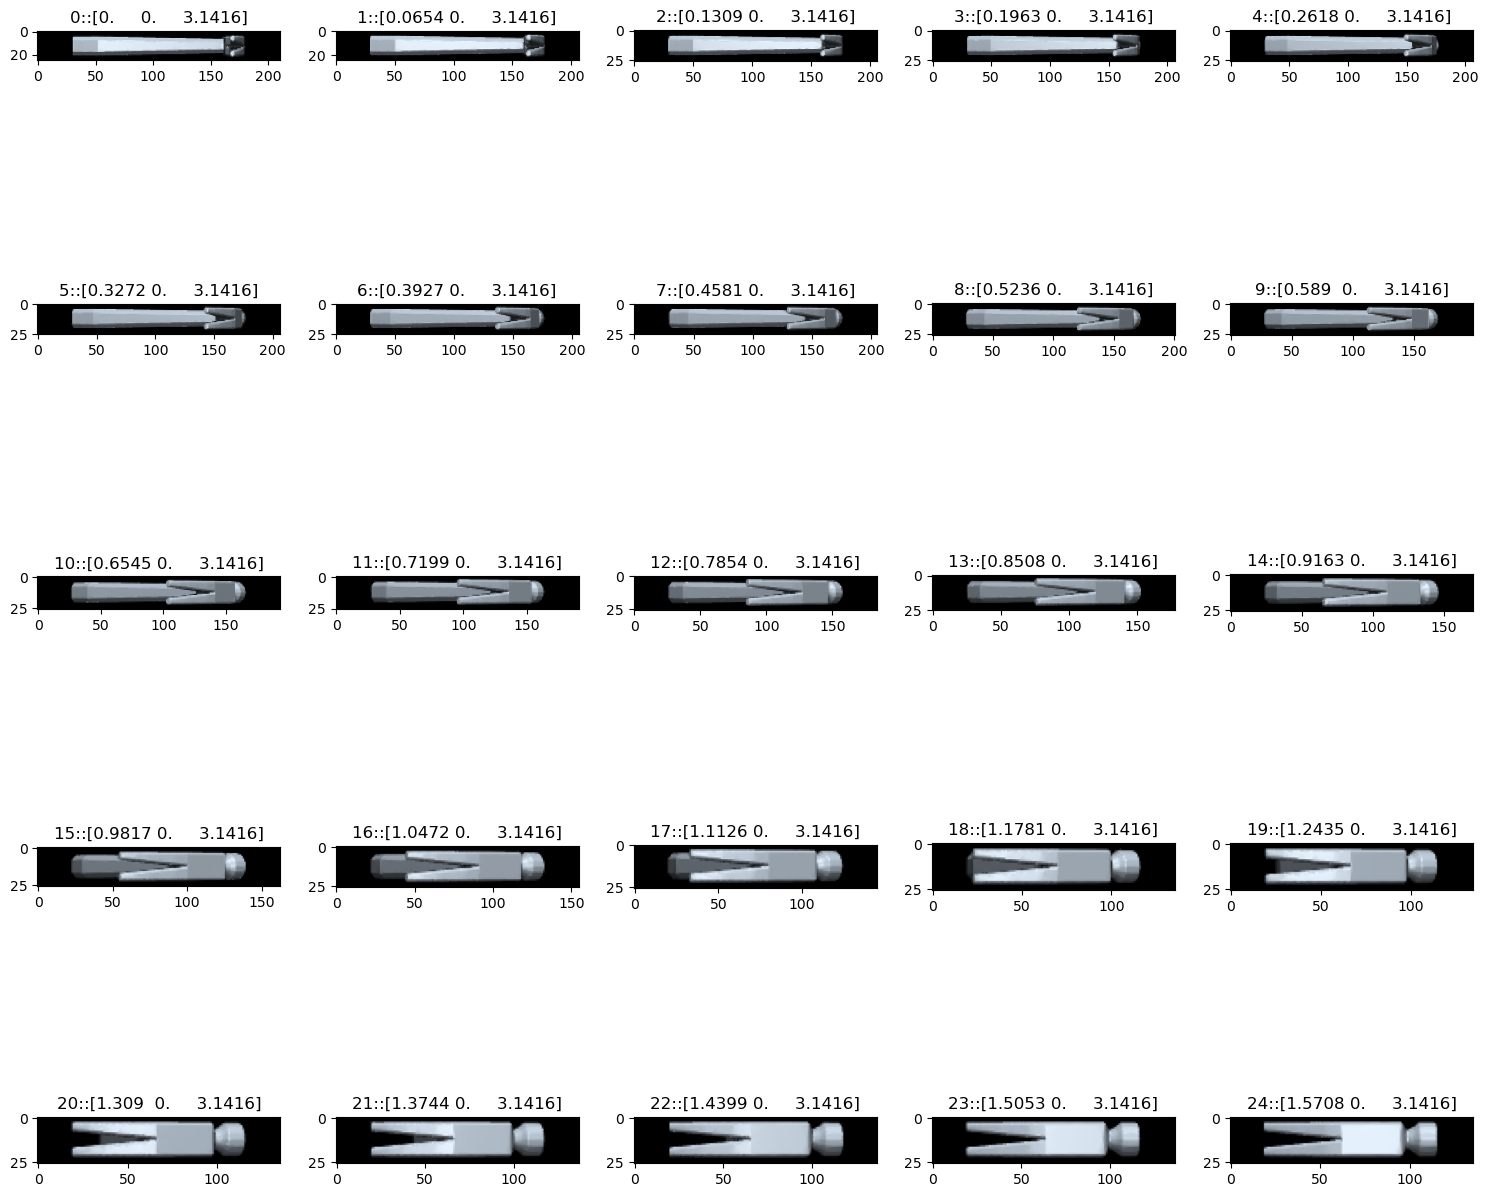

In [9]:

nrows, ncols = (5, 5)
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for idx, pos in enumerate(uni_positions):
    col = idx%ncols
    row = math.floor(idx/ncols)
    ax = axes[row, col]
    ax.imshow(viewer.get_view_cropped(pos, allow_simulation=False, depth=False)[0])
    # print(pos)
    ax.autoscale()
    ax.set_title(f"{idx}::{np.round(pos.orientation, 4)}")
fig.tight_layout()
obj_render_axes = axes

In [10]:
# Evaluate XorDiff 
from evaluate import eval_funcs
from itertools import product

eval_func = eval_funcs.XorDiff(0.1)
eval_results = []

for pos1, pos2 in product(uni_positions, uni_positions):
    img1, img2 = get_views(viewer, pos1, pos2, depth=True)
    result = eval_func(img1, img2)
    eval_results.append(result)
results = np.array(eval_results).reshape(len(uni_positions), -1)

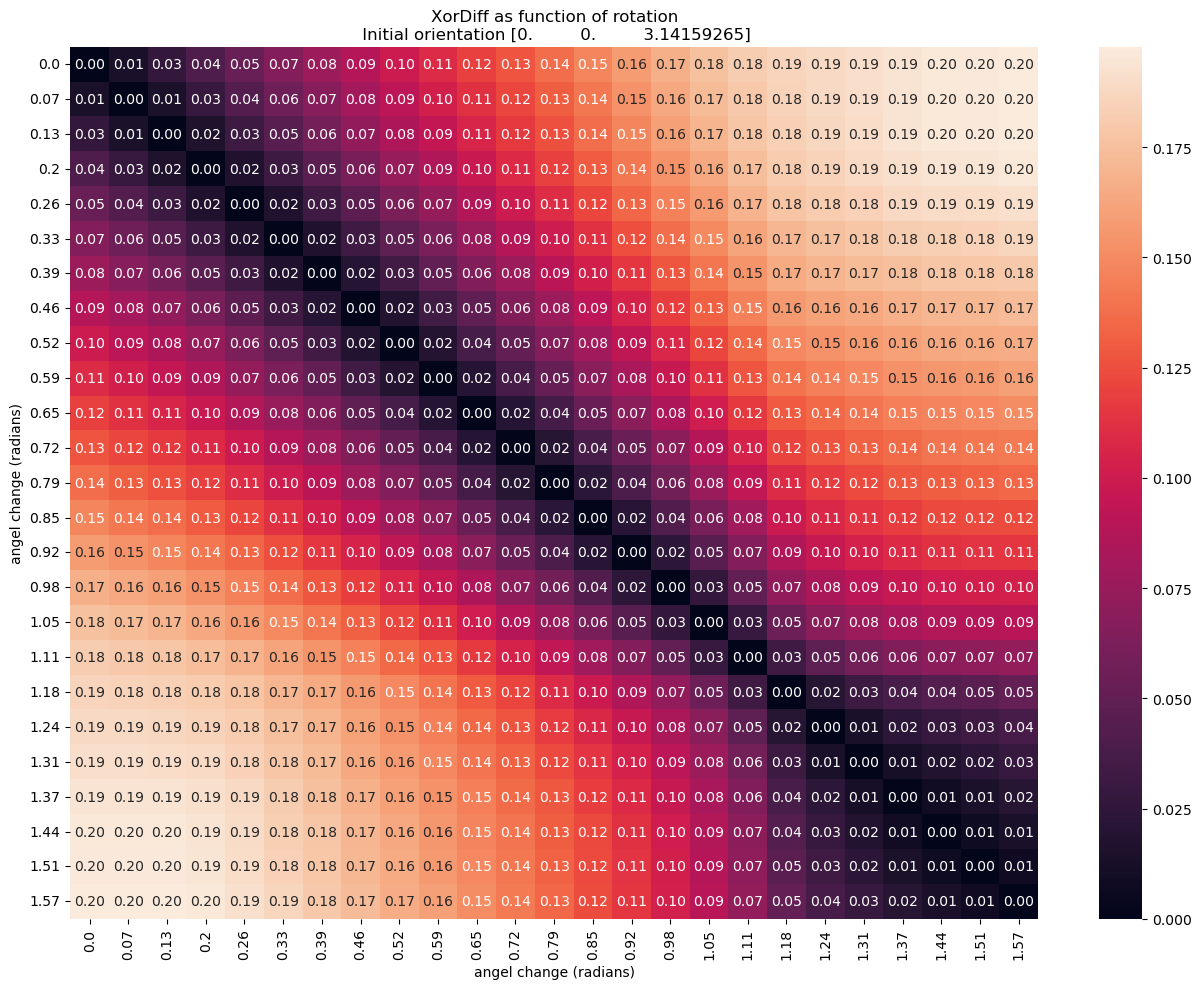

In [11]:
import seaborn as sns 
deltas = np.round(delta, 2)
fig, axes = plt.subplots(figsize=(13,10))
sns.heatmap(results, ax=axes, annot=True, fmt='.2f', xticklabels=(deltas),yticklabels=deltas)
axes.set_title(f"XorDiff as function of rotation\n Initial orientation {init_pos}")
axes.set_xlabel("angel change (radians)")
axes.set_ylabel("angel change (radians)")

axes.tick_params(axis='x', rotation=90)
axes.tick_params(axis='y', rotation=0)
axes.autoscale()
fig.tight_layout()

In [ ]:
heatmap(results, range(len(uni_positions)), range(len(uni_positions)))

Text(0, 0.5, 'XorDiff value')

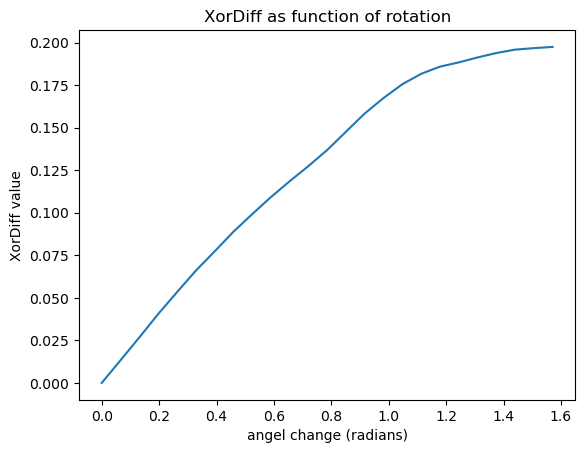

In [12]:
import seaborn as sns 
fig, ax = plt.subplots()
sns.lineplot(x=delta, y=results[0])

ax.set_title("XorDiff as function of rotation")
ax.set_xlabel("angel change (radians)")
ax.set_ylabel("XorDiff value")


In [ ]:
import pickle
from pathlib import Path

def save(file_path: str, obj):
    Path(file_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        with open(file_path, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        raise ValueError(f"error saving object to pickle file: {e}")

def load(file_path: str) -> object:
    try:
        with open(file_path, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"file does not exist: {file_path}")
    except Exception as e:
        raise ValueError(f"error loading object from pickle file: {e}")

In [ ]:
N = 200
positions1 = generate_positions(N)
positions2 = generate_positions(N)

In [ ]:
from evaluate import eval_funcs
from utils.image import ImageUtils

eval_func = eval_funcs.XorDiff(0.1)
eval_results = []

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name) as sim_viewer:
        for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
            img1, img2 = get_views(sim_viewer, pos1, pos2, depth=True)
            result = eval_func(img1, img2)
            eval_results.append(result)

In [ ]:
loss_results = defaultdict(list)

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name) as sim_viewer:
        for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
            img1, img2 = get_views(sim_viewer, pos1, pos2, depth=False)
            for loss_func in LOSS_FUNCTIONS:
                result = loss_func(img1, img2)
                loss_results[type(loss_func).__name__].append(result)

In [ ]:
for k, loss_vals in loss_results.items():
    eval_vals = np.asanyarray(eval_results)
    loss_vals = np.asanyarray(loss_vals)
    print(k, np.corrcoef(eval_vals, loss_vals)[0, 1])

In [ ]:
from matplotlib import pyplot as plt

font = {'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.rcParams['text.usetex'] = False

plt.cla()
fig, axes = plt.subplots(4, 3, sharex=False, figsize=(20, 20))

for i, (loss, values) in enumerate(loss_results.items()):
    ax = axes[i // 3, i % 3]
    ax.set_xlabel("XorDiff")
    ax.set_ylabel(loss)
    ax.set_title(f"{loss} Objective Function", fontweight='bold')

    x = eval_results
    y = np.polyval(np.polyfit(x, values, 1), x)

    ax.plot(x, values, '.', label=loss, markersize=6)
    ax.plot(x, y, ":", linewidth=5)


In [ ]:
from algs.uniform_sampling import UniformSampling
from evaluate import eval_funcs

alg_config = UniformSampling.Config(time_limit=1000, min_samples=343, randomized=False, silent=True)

eval_positions = generate_positions(75)

results = defaultdict(lambda: defaultdict(list))

SELECTED_LOSSES = [
    loss_funcs.IOU(),
    loss_funcs.NormMSE(norm="euclidean"),
    loss_funcs.MutualInformation(bins=100),
    loss_funcs.HausdorffDistance(),
]

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name, True) as sim_viewer, create_viewer(obj_name, False) as world_viewer:
        for loss_func in SELECTED_LOSSES:
            alg = UniformSampling(sim_viewer, loss_func=loss_func)
            evaluator = Evaluator(world_viewer, eval_func=eval_funcs.XorDiff(0.1))
            losses = evaluator.evaluate(alg, alg_config, eval_positions)
            results[obj_name][type(loss_func).__name__].extend(losses)

In [ ]:
print(results.keys())
print(results[results.keys()[0]].keys())

In [ ]:
import statistics

for loss, eval_values in results.items():
    print(f"{loss}: {statistics.mean(eval_values)}")
    print(f"{loss}: {statistics.median(eval_values)}")

In [ ]:
from matplotlib import pyplot as plt

font = {'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

ax = plt.subplot(111)

ax.set_title('Evaluation with Equidistant Sampling Strategy and Different Objective Functions', fontweight='bold')
ax.boxplot(results.values(), labels=results.keys(), sym="", patch_artist=False, autorange=True)
ax.set_ylabel('XorDiff')